<a href="https://colab.research.google.com/github/KimJunOh8060/project/blob/main/geomap%2Cipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !python -m pip uninstall numpy
# !pip install numpy==1.18
# !python -m pip uninstall matplotlib
!pip install osmnx
!pip install matplotlib
# !pip install descartes

In [5]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

%matplotlib inline
# ox.config(log_console=True)
ox.__version__

'1.9.3'

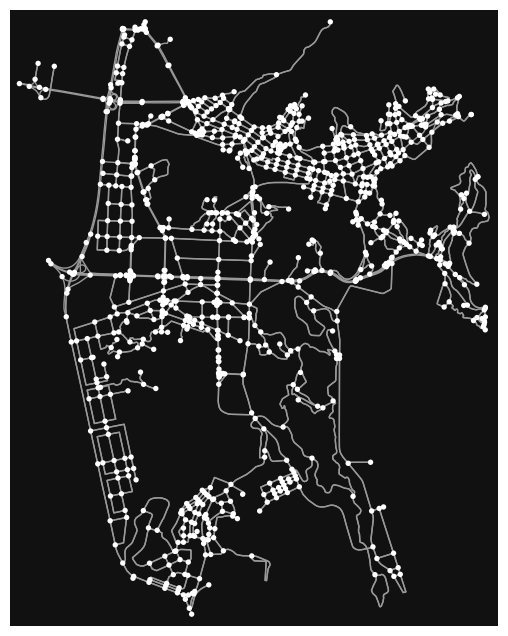

In [6]:
# download/model a street network for some city then visualize it
place = "Saha-gu, Busan, Korea"
G = ox.graph_from_place(place, network_type="drive")
fig, ax = ox.plot_graph(G)

In [7]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

<ipython-input-7-dc557f9fb469>:2: FutureWarning: The `get_undirected` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_undirected` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  M = ox.utils_graph.get_undirected(G)
<ipython-input-7-dc557f9fb469>:5: FutureWarning: The `get_digraph` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_digraph` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  D = ox.utils_graph.get_digraph(G)


In [8]:
address = "" #@param {type:"string"}

In [9]:
# edge의 타입 따라서 도로에 대한 색깔 다르게 표시하기
hwy_colors = {'footway': 'blue',
              'residential': 'red',
              'cycleway': 'orange',
              'service': 'sienna',
              'living street': 'red',
              'secondary': 'green',
              'pedestrian': 'grey'}

In [10]:
# 엣지를 탐색
def find_edges(G, hwys):
    edges = []
    for u, v, k, data in G.edges(keys=True, data='highway'):
        check1 = isinstance(data, str) and data not in hwys
        check2 = isinstance(data, list) and all([d not in hwys for d in data])
        if check1 or check2:
            edges.append((u, v, k))
    return set(edges)

In [11]:
# hwy 이 정해지지 않은 경우는 black
G_tmp = G.copy()
G_tmp.remove_edges_from(G.edges - find_edges(G, hwy_colors.keys()))
m = ox.plot_graph_folium(G_tmp, popup_attribute='highway', weight=2, color='black')

# 지도 위에서 Hwy_colors에서 정해진 타입에 따라 추가적인 edge를 그림
for hwy, color in hwy_colors.items():
    G_tmp = G.copy()
    G_tmp.remove_edges_from(find_edges(G_tmp, [hwy]))
    if G_tmp.edges:
        m = ox.plot_graph_folium(G_tmp,
                                 graph_map=m,
                                 popup_attribute='highway',
                                 weight=2,
                                 color=color)

<ipython-input-11-5dacb488220f>:4: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  m = ox.plot_graph_folium(G_tmp, popup_attribute='highway', weight=2, color='black')
<ipython-input-11-5dacb488220f>:11: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  m = ox.plot_graph_folium(G_tmp,
<ipython-input-11-5dacb488220f>:11: FutureWarni

In [12]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

38065159.10783804

In [13]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 1037,
 'm': 2803,
 'k_avg': 5.405978784956606,
 'edge_length_total': 435344.75699999894,
 'edge_length_avg': 155.31386264716338,
 'streets_per_node_avg': 3.0540019286403086,
 'streets_per_node_counts': {0: 0, 1: 99, 2: 1, 3: 692, 4: 235, 5: 10},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09546769527483125,
  2: 0.0009643201542912247,
  3: 0.6673095467695275,
  4: 0.2266152362584378,
  5: 0.009643201542912247},
 'intersection_count': 938,
 'street_length_total': 246196.5210000003,
 'street_segment_count': 1574,
 'street_length_avg': 156.41456226175367,
 'circuity_avg': 1.09503488601991,
 'self_loop_proportion': 0.0025412960609911056,
 'clean_intersection_count': 746,
 'node_density_km': 27.242760159288814,
 'intersection_density_km': 24.641956633956518,
 'edge_density_km': 11436.83008828818,
 'street_density_km': 6467.765451932806,
 'clean_intersection_density_km': 19.59797403937267}

In [14]:
m

In [15]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

In [16]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

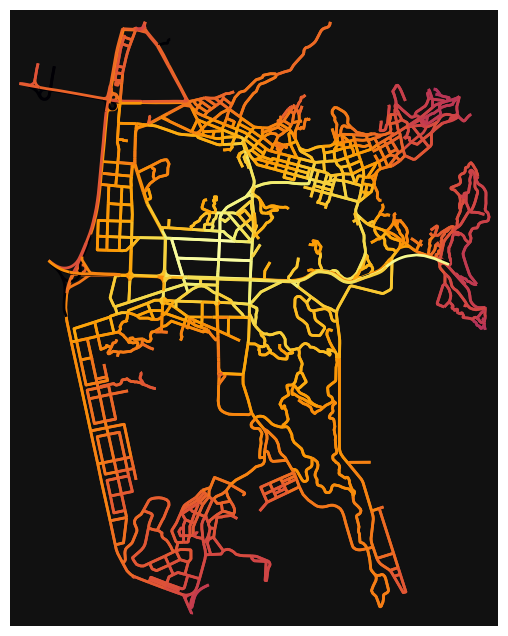

In [17]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)